# XLNet version 1

Hate speech identification project, D7047E <br>
Binary text classification task using pretrained XLNet models

In [11]:
""" 
%pip install numpy
%pip install torch
%pip install torchvision
%pip install sentencepiece
%pip install transformers
%pip install datasets
%pip install evaluate
%pip install accelerate
%pip install imbalanced-learn
"""

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torchvision

# Hugging Face
from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import datasets
import evaluate

# Misc
from tqdm import tqdm, trange
import sentencepiece as spm
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

if torch.cuda.is_available(): torch.cuda.empty_cache()

using cuda


In [12]:
# Constants and vars

# aux files
path_tr = r"..\\OLID_Tain.txt" 
path_te_a = r"..\\OLID_TEST.txt" 
path_spm = r"data\\proj_xlnet" # +.model / +.vocab
path_output = r"trained\\"

# Constants
GLOBAL_SEED = 1337
TOKENIZER_MAX_LENGTH = 128 #100 works with 1 epoch 
torch.manual_seed(GLOBAL_SEED)

tokenizer_config = {
    "padding": "max_length", 
    "truncation": "longest_first",
    "max_length": TOKENIZER_MAX_LENGTH,
    #"add_special_tokens": True,
    #"return_tensors": "pt",
    #"return_token_type_ids": False, 
    #"return_attention_mask": True, 
    #"pad_to_max_length": False
}

In [13]:
tokenizer = XLNetTokenizer.from_pretrained(
    'xlnet-base-cased',
    #additional_special_tokens = ["@USER"], NOTE THIS LINE RUINS EVERYTHING
    # ^ this note was written at 1:30 am on a tuesday
    device=device
)

def tokenize_examples(examples):
    return tokenizer(examples["text"], **tokenizer_config)

In [14]:
# Load and split dataset
olid_dataset = pd.read_csv(path_tr, sep="\t", names=["id","text","label","other_1","other_2"])
olid_dataset = olid_dataset.drop(axis=0, index=0) # Remove column names
olid_dataset = olid_dataset.drop(axis=1, labels=["id", "other_1", "other_2"]).to_dict()
for i in trange(len(olid_dataset["label"])):
    olid_dataset["label"][i+1] = 1 if olid_dataset["label"][i+1] == "OFF" else 0 

olid_dataset = {
    "label": [y for y in olid_dataset["label"].values()],
    "text": [x for x in olid_dataset["text"].values()]     
}

olid_dataset = Dataset.from_dict(olid_dataset)
olid_dataset = olid_dataset.map(tokenize_examples, batched=True)
print(olid_dataset)

100%|██████████| 13240/13240 [00:00<00:00, 2632125.56it/s]


Map:   0%|          | 0/13240 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 13240
})


In [15]:
def _get_split(s):
    return [int(x * olid_dataset.num_rows) for x in s]
    
split = _get_split([0.7, 0.1, 0.2])
olid_train = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[0]))
olid_val = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[1]))
olid_test = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[2]))
print(olid_train)
print(olid_val)
print(olid_test)


Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9268
})
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1324
})
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2648
})


In [16]:
# Prevent overfitting by oversampling class 1
sm = SMOTE()

X = olid_train["input_ids"]
y = olid_train["label"]

X = np.array(X)
y = np.array(y)

X_res, y_res = sm.fit_resample(X, y)
print(X_res.shape, X.shape)

X_res = [tokenizer.decode(X_res[i], skip_special_tokens=True) for i in range(len(X_res))]

olid_train_os = Dataset.from_dict({"text": X_res, "label":y_res})
olid_train_os = olid_train_os.map(tokenize_examples, batched=True)

(12412, 128) (9268, 128)


Map:   0%|          | 0/12412 [00:00<?, ? examples/s]

In [17]:
def getTrainLabelDistrib(loader):
    labels_dist = {}
    for e in loader:
        lab = e["label"]
        if lab in labels_dist:
            labels_dist[lab] += 1
        else:
            labels_dist[lab] = 0
    print(labels_dist)

In [18]:
#getTrainLabelDistrib(olid_test)
#getTrainLabelDistrib(olid_train)
#getTrainLabelDistrib(olid_val)
getTrainLabelDistrib(olid_train_os)

{0: 6205, 1: 6205}


In [19]:
# Model 
# docs: https://huggingface.co/docs/transformers/model_doc/xlnet

xlnet_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", 
    num_labels=2
)
xlnet_model.to(device)

print(xlnet_model.config)
print(next(xlnet_model.parameters()).is_cuda)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.40.2",
  "untie_r": true,
  "use_mems_eval": true,
  "use_mems_train": false,
  "vocab_size": 32000
}

True


In [20]:
# Fine-tuning
# https://huggingface.co/docs/transformers/training

metric = evaluate.load("accuracy")
def compute_model_metrics(eval_pred):
    global metric
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metric.compute(predictions=preds, references=labels)


device_batch_size = 32
grad_steps = 8
calc_steps = len(olid_train_os) // (device_batch_size * grad_steps * 5) 


tr_args = TrainingArguments(
    do_train=True, do_eval=True, evaluation_strategy="epoch", output_dir=path_output,
    
    logging_steps=calc_steps, # For larger size dataset
    eval_accumulation_steps=10, # To prevent cuda OOM after training
    per_device_eval_batch_size=device_batch_size,
    per_device_train_batch_size=device_batch_size,
    bf16=True, 
    # dataloader_pin_memory=True, dataloader_num_workers=8, # Load data on GPU
    #fp16=True,

    num_train_epochs = 10, 
    gradient_accumulation_steps=grad_steps,
    weight_decay=0.1,
    save_strategy="no",
    # use_cpu=True
)


trainer = Trainer(
    model=xlnet_model,
    args=tr_args,
    train_dataset=olid_train,
    eval_dataset=olid_val,
    compute_metrics=compute_model_metrics
)
trainer.train()

  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.6457, 'grad_norm': 5.486652851104736, 'learning_rate': 4.875e-05, 'epoch': 0.25}
{'loss': 0.6121, 'grad_norm': 5.577016830444336, 'learning_rate': 4.75e-05, 'epoch': 0.5}
{'loss': 0.5402, 'grad_norm': 5.1810126304626465, 'learning_rate': 4.6250000000000006e-05, 'epoch': 0.74}
{'loss': 0.4753, 'grad_norm': 5.3945631980896, 'learning_rate': 4.5e-05, 'epoch': 0.99}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.44203099608421326, 'eval_accuracy': 0.8074018126888217, 'eval_runtime': 8.7755, 'eval_samples_per_second': 150.875, 'eval_steps_per_second': 4.786, 'epoch': 0.99}
{'loss': 0.4854, 'grad_norm': 7.213375091552734, 'learning_rate': 4.375e-05, 'epoch': 1.24}
{'loss': 0.4463, 'grad_norm': 2.9655590057373047, 'learning_rate': 4.25e-05, 'epoch': 1.49}
{'loss': 0.4277, 'grad_norm': 3.9805123805999756, 'learning_rate': 4.125e-05, 'epoch': 1.74}
{'loss': 0.4595, 'grad_norm': 3.552178382873535, 'learning_rate': 4e-05, 'epoch': 1.99}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.3450039029121399, 'eval_accuracy': 0.851963746223565, 'eval_runtime': 7.047, 'eval_samples_per_second': 187.881, 'eval_steps_per_second': 5.96, 'epoch': 1.99}
{'loss': 0.3804, 'grad_norm': 1.936589002609253, 'learning_rate': 3.875e-05, 'epoch': 2.23}
{'loss': 0.3654, 'grad_norm': 2.3801538944244385, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.48}
{'loss': 0.3775, 'grad_norm': 3.886749505996704, 'learning_rate': 3.625e-05, 'epoch': 2.73}
{'loss': 0.3916, 'grad_norm': 3.0534963607788086, 'learning_rate': 3.5e-05, 'epoch': 2.98}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.27530571818351746, 'eval_accuracy': 0.8844410876132931, 'eval_runtime': 7.409, 'eval_samples_per_second': 178.702, 'eval_steps_per_second': 5.669, 'epoch': 2.98}
{'loss': 0.3168, 'grad_norm': 3.4640796184539795, 'learning_rate': 3.375000000000001e-05, 'epoch': 3.23}
{'loss': 0.3058, 'grad_norm': 3.0655136108398438, 'learning_rate': 3.2500000000000004e-05, 'epoch': 3.48}
{'loss': 0.2897, 'grad_norm': 2.8209948539733887, 'learning_rate': 3.125e-05, 'epoch': 3.72}
{'loss': 0.3091, 'grad_norm': 3.218364715576172, 'learning_rate': 3e-05, 'epoch': 3.97}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.19264012575149536, 'eval_accuracy': 0.9441087613293051, 'eval_runtime': 7.135, 'eval_samples_per_second': 185.564, 'eval_steps_per_second': 5.886, 'epoch': 4.0}
{'loss': 0.2497, 'grad_norm': 5.211942195892334, 'learning_rate': 2.8749999999999997e-05, 'epoch': 4.22}
{'loss': 0.2171, 'grad_norm': 6.918621063232422, 'learning_rate': 2.7500000000000004e-05, 'epoch': 4.47}
{'loss': 0.2146, 'grad_norm': 3.7303125858306885, 'learning_rate': 2.625e-05, 'epoch': 4.72}
{'loss': 0.2313, 'grad_norm': 2.990088939666748, 'learning_rate': 2.5e-05, 'epoch': 4.97}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.10194070637226105, 'eval_accuracy': 0.9622356495468278, 'eval_runtime': 9.034, 'eval_samples_per_second': 146.557, 'eval_steps_per_second': 4.649, 'epoch': 4.99}
{'loss': 0.1679, 'grad_norm': 3.1536412239074707, 'learning_rate': 2.375e-05, 'epoch': 5.21}
{'loss': 0.1661, 'grad_norm': 3.4551992416381836, 'learning_rate': 2.25e-05, 'epoch': 5.46}
{'loss': 0.1513, 'grad_norm': 3.8979573249816895, 'learning_rate': 2.125e-05, 'epoch': 5.71}
{'loss': 0.1906, 'grad_norm': 3.540104627609253, 'learning_rate': 2e-05, 'epoch': 5.96}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.06868594139814377, 'eval_accuracy': 0.9788519637462235, 'eval_runtime': 9.12, 'eval_samples_per_second': 145.175, 'eval_steps_per_second': 4.605, 'epoch': 5.99}
{'loss': 0.1185, 'grad_norm': 2.565863609313965, 'learning_rate': 1.8750000000000002e-05, 'epoch': 6.21}
{'loss': 0.1327, 'grad_norm': 10.15497875213623, 'learning_rate': 1.75e-05, 'epoch': 6.46}
{'loss': 0.1304, 'grad_norm': 7.215969562530518, 'learning_rate': 1.6250000000000002e-05, 'epoch': 6.7}
{'loss': 0.1254, 'grad_norm': 5.080470085144043, 'learning_rate': 1.5e-05, 'epoch': 6.95}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.04863986745476723, 'eval_accuracy': 0.9848942598187311, 'eval_runtime': 7.641, 'eval_samples_per_second': 173.276, 'eval_steps_per_second': 5.497, 'epoch': 6.98}
{'loss': 0.1069, 'grad_norm': 3.8032662868499756, 'learning_rate': 1.3750000000000002e-05, 'epoch': 7.2}
{'loss': 0.1047, 'grad_norm': 5.640691757202148, 'learning_rate': 1.25e-05, 'epoch': 7.45}
{'loss': 0.1028, 'grad_norm': 4.50432014465332, 'learning_rate': 1.125e-05, 'epoch': 7.7}
{'loss': 0.0877, 'grad_norm': 4.456331729888916, 'learning_rate': 1e-05, 'epoch': 7.94}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.03727085888385773, 'eval_accuracy': 0.9886706948640483, 'eval_runtime': 8.392, 'eval_samples_per_second': 157.769, 'eval_steps_per_second': 5.005, 'epoch': 8.0}
{'loss': 0.0802, 'grad_norm': 5.154690265655518, 'learning_rate': 8.75e-06, 'epoch': 8.19}
{'loss': 0.0771, 'grad_norm': 2.710310459136963, 'learning_rate': 7.5e-06, 'epoch': 8.44}
{'loss': 0.0758, 'grad_norm': 3.08478045463562, 'learning_rate': 6.25e-06, 'epoch': 8.69}
{'loss': 0.0887, 'grad_norm': 3.3802008628845215, 'learning_rate': 5e-06, 'epoch': 8.94}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.022834537550807, 'eval_accuracy': 0.993202416918429, 'eval_runtime': 8.775, 'eval_samples_per_second': 150.883, 'eval_steps_per_second': 4.786, 'epoch': 8.99}
{'loss': 0.0693, 'grad_norm': 5.052248001098633, 'learning_rate': 3.75e-06, 'epoch': 9.19}
{'loss': 0.0584, 'grad_norm': 2.831624984741211, 'learning_rate': 2.5e-06, 'epoch': 9.43}
{'loss': 0.0722, 'grad_norm': 4.4917497634887695, 'learning_rate': 1.25e-06, 'epoch': 9.68}
{'loss': 0.0743, 'grad_norm': 2.6397526264190674, 'learning_rate': 0.0, 'epoch': 9.93}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.020529361441731453, 'eval_accuracy': 0.9947129909365559, 'eval_runtime': 6.89, 'eval_samples_per_second': 192.164, 'eval_steps_per_second': 6.096, 'epoch': 9.93}
{'train_runtime': 1372.8619, 'train_samples_per_second': 67.509, 'train_steps_per_second': 0.262, 'train_loss': 0.2480521000093884, 'epoch': 9.93}


TrainOutput(global_step=360, training_loss=0.2480521000093884, metrics={'train_runtime': 1372.8619, 'train_samples_per_second': 67.509, 'train_steps_per_second': 0.262, 'total_flos': 6555949873330176.0, 'train_loss': 0.2480521000093884, 'epoch': 9.931034482758621})

In [21]:
predictions = trainer.predict(olid_test)
print(predictions.predictions.shape, predictions.label_ids.shape) 
preds = np.argmax(predictions.predictions, axis=-1)

labels_t = {"0":0, "1":0}
labels_p = {"0":0, "1":0}
for i in range(len(predictions.predictions)):
    #print(predictions.label_ids[i], preds[i], predictions.predictions[i]) # Debug overfitting
    labels_t[str(predictions.label_ids[i])] += 1
    labels_p[str(preds[i])] += 1
print(f"True labels {labels_t}")
print(f"Predicted labels {labels_p}")

loss_his = {"tr_loss":[], "val_loss":[]}

for e in trainer.state.log_history:
    if "loss" in e:
        loss_his["tr_loss"].append(e["loss"])
    elif "eval_loss" in e:
        loss_his["val_loss"].append(e["eval_loss"])

metric = evaluate.combine(["accuracy", "f1", "precision", "recall", "BucketHeadP65/confusion_matrix"])
metric.compute(predictions=preds, references=predictions.label_ids)

  0%|          | 0/83 [00:00<?, ?it/s]

(2648, 2) (2648,)
True labels {'0': 1778, '1': 870}
Predicted labels {'0': 1781, '1': 867}


{'accuracy': 0.995845921450151,
 'f1': 0.9936672423719056,
 'precision': 0.9953863898500577,
 'recall': 0.9919540229885058,
 'confusion_matrix': array([[1774,    4],
        [   7,  863]], dtype=int64)}

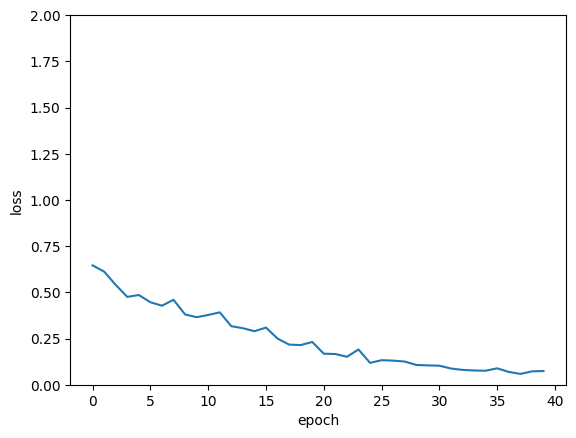

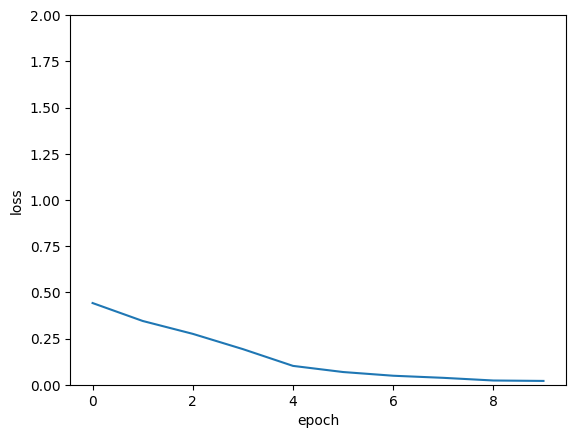

In [23]:
plt.plot(loss_his["tr_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()

plt.plot(loss_his["val_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()